In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import torch 

import torch.nn as nn 

from evaluation import get_actual_demand, get_known

from utils import load_problem_data

In [16]:
demand, _ , _ , _= load_problem_data() ##pd.read_csv('./data/demand.csv')
demand

server_type = "CPU.S1"
latency_sensitivity = "low"

lookback = 25
lookahead = 10

seeds = range(0,10000,100)



In [17]:
def getSeedDemand(seed):
    

    ## set random seed for numpy
    np.random.seed(seed)

    # get the demand under this seed
    seeded_demand = get_actual_demand(demand)



    ## only get rows for this server type
    seeded_demand = seeded_demand.loc[    (seeded_demand["server_generation"]== server_type)]

    seeded_demand = seeded_demand.reset_index()

    ## remove all other rows, apart from the latency_sensitivity we are interested in 
    seeded_demand = seeded_demand[ [   latency_sensitivity ] ]


    seeded_demand.index.names = ['time_step']



    ## add in missing values for timestep
    for t in range(get_known("time_steps")):
        if t not in seeded_demand.index:
            seeded_demand.loc[t,latency_sensitivity] = 0




    ## add zeroes for lookback values before 0, so we can predict something for the first timesteps
    for t in range(0,-lookback,-1):
        seeded_demand.loc[t,latency_sensitivity] = 0

    ## add zeroes for lookahead values before 0, so we can predict something for the last timesteps
    for t in range(lookahead):
        seeded_demand.loc[get_known("time_steps")+t,latency_sensitivity] = 0


    seeded_demand = seeded_demand.sort_index()

    return seeded_demand

data = getSeedDemand(0)
data

latency_sensitivity,low
time_step,
-24,0.0
-23,0.0
-22,0.0
-21,0.0
-20,0.0
...,...
173,0.0
174,0.0
175,0.0


In [18]:
## set device to gpu if possible
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [19]:
from copy import deepcopy as dc

## get dataframe with past and future values for demand
def prepare_dataframe_for_lstm(df, back_steps, forward_steps):
    df = dc(df)


    for i in range(1, forward_steps):
        df[f'{latency_sensitivity}(t+{i})'] = df[latency_sensitivity].shift(-i)

    for i in range(1, back_steps+1):
        df[f'{latency_sensitivity}(t-{i})'] = df[latency_sensitivity].shift(i)

    
    

    df.dropna(inplace=True)

    return df



In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = None

def getDataNumpyArray(seed):

    data = getSeedDemand(seed)

    shifted_df = prepare_dataframe_for_lstm(data, lookback, lookahead)

    shifted_df_as_np = shifted_df.to_numpy()

    global scaler

    scaler = MinMaxScaler(feature_range=(-1,1))

    # scaler = StandardScaler()


    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

    X = shifted_df_as_np[:, lookahead:]

    Y = shifted_df_as_np[:,:lookahead]

    ## flip matrix, so values further in the past, come first in the matrix
    X = dc(np.flip(X,axis=1))


    ## flip matrix, so values further in the past, come first in the matrix
    X = dc(np.flip(X,axis=1))

    X = X.reshape( (-1, lookback, 1) )

    Y = Y.reshape( (-1, lookahead, 1) )

    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()

    return X,Y



    





    

In [21]:
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):


    def __init__(self, data):
        
        self.data = data
        

    
    def __len__(self):
        


        return len(self.data) * len(self.data[0][0])
    
    


    def __getitem__(self, i ):

        timeseries = i // len(self.data[0][0])

        row = i % len(self.data[0][0])

      

        return self.data[timeseries][0][row], self.data[timeseries][1][row]





In [22]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_stacked_layers, lookahead):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, lookahead)



    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



In [23]:
def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        output = torch.unsqueeze(output,2)
       
        
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print('EPOCH {0}, Loss: {1:.3f}'.format(epoch+1,
                                            running_loss))
            
    print()

CPU.S1 high
EPOCH 1, Loss: 264.662

EPOCH 2, Loss: 100.472

EPOCH 3, Loss: 82.019

EPOCH 4, Loss: 74.757

EPOCH 5, Loss: 72.293

EPOCH 6, Loss: 71.110

EPOCH 7, Loss: 70.357

EPOCH 8, Loss: 69.641

EPOCH 9, Loss: 68.680

EPOCH 10, Loss: 67.472

R2: 0.7724840044975281
0


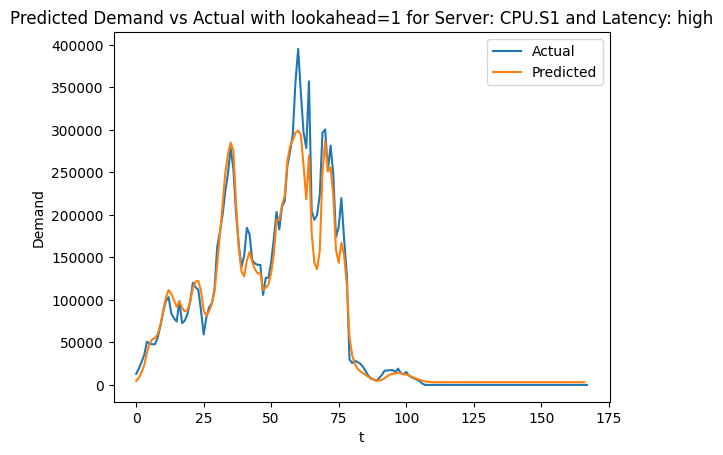

3


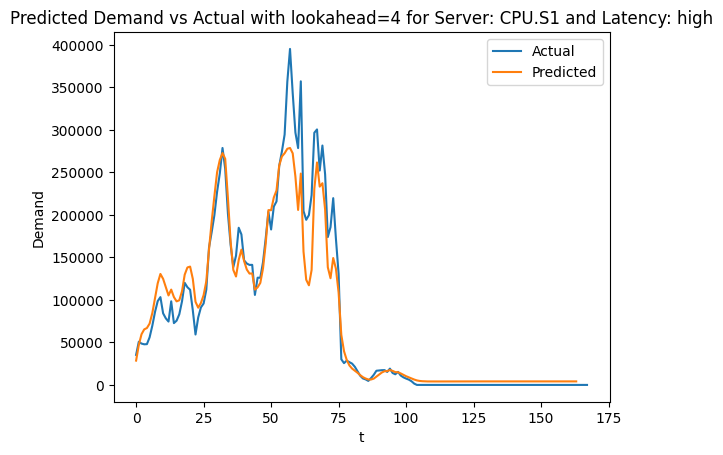

6


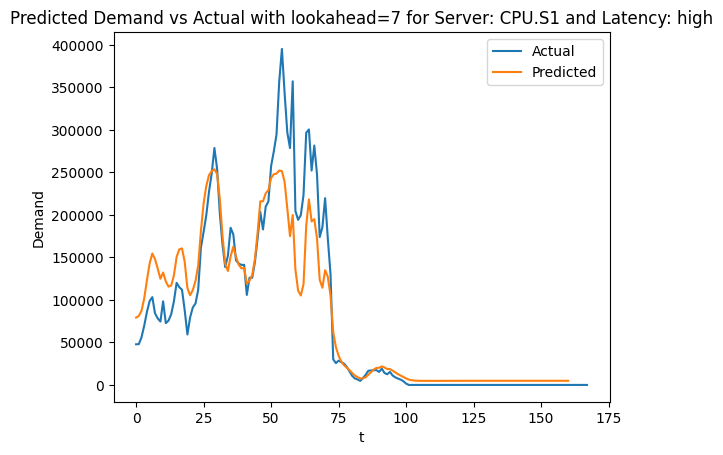

9


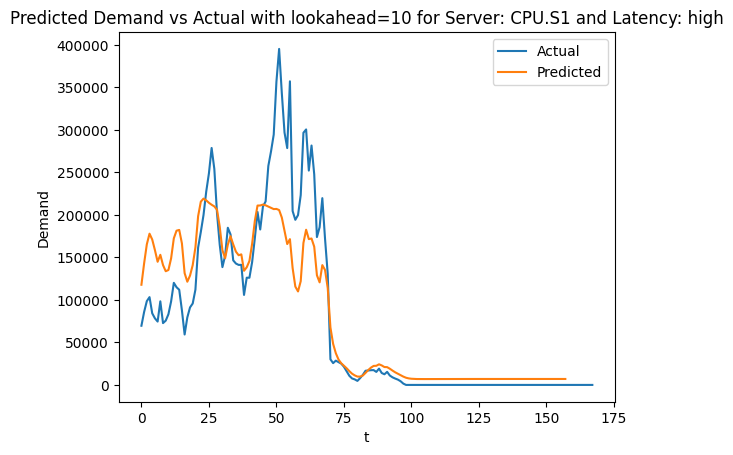

CPU.S1 medium
EPOCH 1, Loss: 294.275

EPOCH 2, Loss: 101.721

EPOCH 3, Loss: 83.973

EPOCH 4, Loss: 78.207



In [24]:
from torcheval.metrics import R2Score
from torch.utils.data import DataLoader


demand, _ , _ , _= load_problem_data() ##pd.read_csv('./data/demand.csv')

lookback = 25
lookahead = 10

seeds = range(0,10000,100)

test_seeds = range(10000,11000,100)

batch_size = 16 


for server in get_known("server_generation"):
    for latency in get_known("latency_sensitivity"):

        latency_sensitivity = latency
        server_type = server

        print(server_type , latency_sensitivity )

        datalist = [getDataNumpyArray(seed) for seed in seeds] 
        train_dataset = TimeSeriesDataset(datalist)

        

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)



        

        ## create model 
        model = LSTM(1, 40, 10, lookahead)
        model.to(device)

        learning_rate = 0.0001

        num_epochs = 10

        loss_function = nn.MSELoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):

            train_one_epoch()


        metric = R2Score()
        for test_seed in test_seeds:
            test_X, test_Y = getDataNumpyArray(test_seed)
            

            with torch.no_grad():

                predicted = model(test_X.to(device)).to("cpu")
                test_Y = torch.squeeze(test_Y)
                # test_Y = torch.from_numpy(test_Y)

              

                
                for i in range(lookahead):

                    
                    metric.update(predicted[:,i],test_Y[:,i])

        print(f"R2: {metric.compute()}")


        test_seed = 11001
        test_X, test_Y = getDataNumpyArray(test_seed)

        with torch.no_grad():

            predicted = model(test_X.to(device)).to("cpu").numpy()


        real_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
        real_value_dummies[:, :lookahead] = np.squeeze(test_Y)
        real_value_dummies = scaler.inverse_transform(real_value_dummies)

        scaled_test_Y = dc(real_value_dummies[:, :lookahead])


        predicted_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
        predicted_value_dummies[:, :lookahead] = np.squeeze(predicted)
        predicted_value_dummies = scaler.inverse_transform(predicted_value_dummies)

        scaled_predictions = dc(predicted_value_dummies[:, :lookahead])


        for i in range(0,lookahead,3):
            print(i)
            predicted_i = scaled_predictions[:,i]
            y_i = scaled_test_Y[:,i]

            plt.title(f"Predicted Demand vs Actual with lookahead={i+1} for Server: {server_type} and Latency: {latency_sensitivity}")

            plt.plot(y_i, label='Actual')
            plt.plot(predicted_i[i+1:], label='Predicted')
            plt.xlabel('t')
            plt.ylabel('Demand')
            plt.legend()
            plt.show()
            

            



        


        PATH = f"lstm_models/{server_type}_{latency}"
        torch.save(model.state_dict(), PATH)


        

0


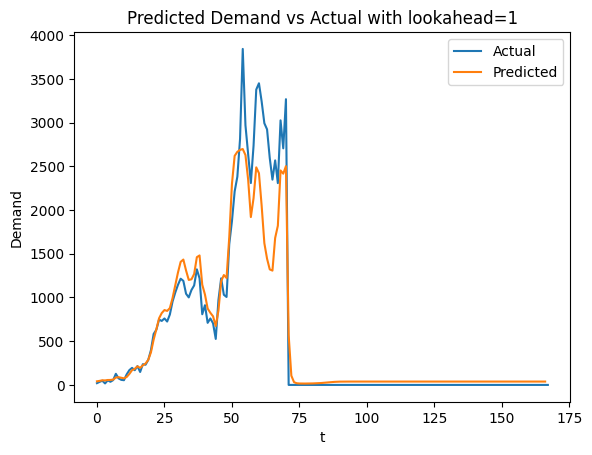

3


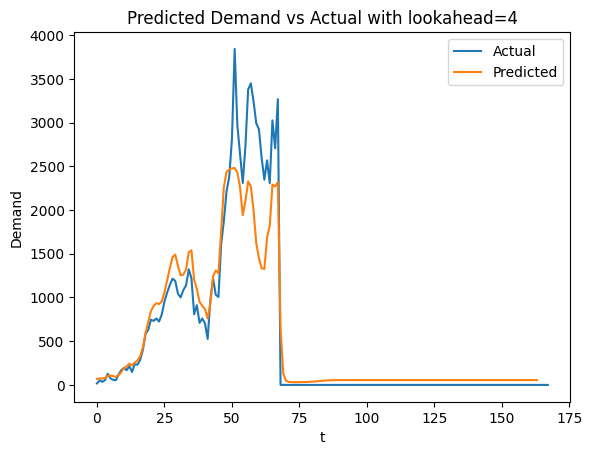

6


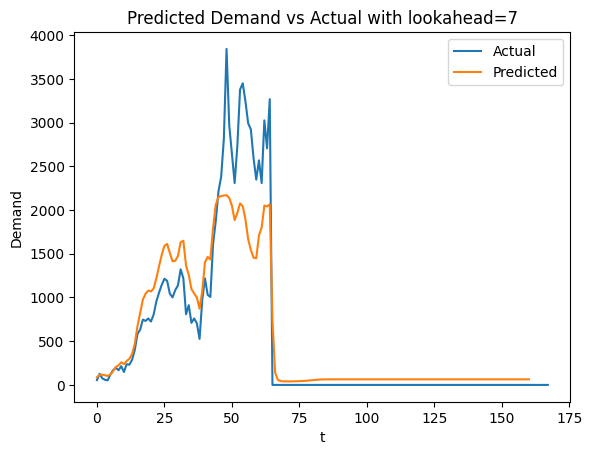

9


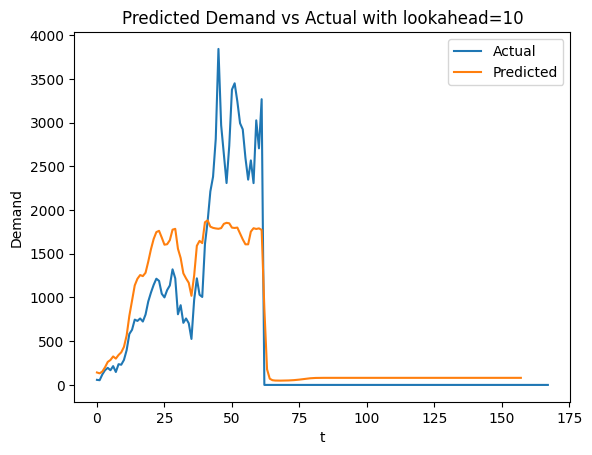

In [14]:
test_seed = 100

test_X, test_Y = getDataNumpyArray(test_seed)

with torch.no_grad():

    predicted = model(test_X.to(device)).to("cpu").numpy()


real_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
real_value_dummies[:, :lookahead] = np.squeeze(test_Y)
real_value_dummies = scaler.inverse_transform(real_value_dummies)

scaled_test_Y = dc(real_value_dummies[:, :lookahead])


predicted_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
predicted_value_dummies[:, :lookahead] = np.squeeze(predicted)
predicted_value_dummies = scaler.inverse_transform(predicted_value_dummies)

scaled_predictions = dc(predicted_value_dummies[:, :lookahead])


for i in range(0,lookahead,3):
    print(i)
    predicted_i = scaled_predictions[:,i]
    y_i = scaled_test_Y[:,i]

    plt.title(f"Predicted Demand vs Actual with lookahead={i+1}")

    plt.plot(y_i, label='Actual')
    plt.plot(predicted_i[i+1:], label='Predicted')
    plt.xlabel('t')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

